In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load cleaned dataset
df = pd.read_csv('cleaned_student_depression.csv')


In [3]:
df.head()

,Gender,Age,Profession,Academic_Pressure,CGPA,Study_Satisfaction,Sleep_Duration,Dietary_Habits,Degree,Suicidal_Thoughts,Study_Hours,Financial_Stress,Mental_Illness_History,Depression
0,Male,33.0,Student,5.0,8.97,2.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,Female,24.0,Student,2.0,5.90,5.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,Male,31.0,Student,3.0,7.03,5.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,Female,28.0,Student,3.0,5.59,2.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,Female,25.0,Student,4.0,8.13,3.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


In [4]:
# split the data set into independent and dependent variables
X = df.drop(columns=['Depression'])
y = df['Depression']
 

In [5]:
# split data into train and test data set, no validation set, because to use cross validation 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



In [6]:

# #  categorical columns to do encoding  
# categorical_cols= df.select_dtypes(include=['object']).columns.tolist()

# print(f"categorical colums are : {categorical_cols}")

# Show unique values in categorical columns
for col in df.select_dtypes(include='object'):
    print(f"{col} : {df[col].nunique()}:\n {df[col].unique()}")
    


Gender : 2:
 ['Male' 'Female']
Profession : 2:
 ['Student' 'Other']
Sleep_Duration : 4:
 ['5-6 hours' 'Less than 5 hours' '7-8 hours' 'More than 8 hours']
Dietary_Habits : 3:
 ['Healthy' 'Moderate' 'Unhealthy']
Degree : 28:
 ['B.Pharm' 'BSc' 'BA' 'BCA' 'M.Tech' 'PhD' 'Class 12' 'B.Ed' 'LLB' 'BE'
 'M.Ed' 'MSc' 'BHM' 'M.Pharm' 'MCA' 'MA' 'B.Com' 'MD' 'MBA' 'MBBS' 'M.Com'
 'B.Arch' 'LLM' 'B.Tech' 'BBA' 'ME' 'MHM' 'Others']
Suicidal_Thoughts : 2:
 ['Yes' 'No']
Mental_Illness_History : 2:
 ['No' 'Yes']


In [7]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#  Column groups
onehot_cols = ['Gender', 'Profession', 'Degree','Suicidal_Thoughts', 'Mental_Illness_History']
ordinal_cols = ['Sleep_Duration', 'Dietary_Habits']

# Define category orders for ordinal features
ordinal_categories = [
    ['Less than 5 hours', '5-6 hours', '7-8 hours', 'More than 8 hours'],  
    ['Unhealthy', 'Moderate', 'Healthy']                                                                                                 # Mental_Illness_History
]

# Define ColumnTransformer
encoder = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore',drop='first', sparse_output=False), onehot_cols),
        ('ordinal', OrdinalEncoder(categories=ordinal_categories), ordinal_cols)
    ],
    remainder='passthrough' 
)



In [8]:

# Wrap the preprocessor in a pipeline with StandardScaler
pipeline = Pipeline([
    ('preprocessing', encoder),
    ('scaler', StandardScaler())
])

In [9]:

# Fit and transform the training set, transform the test set
X_train_encoded_scaled = pipeline.fit_transform(X_train)
X_test_encoded_scaled = pipeline.transform(X_test)

In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(X_train_encoded_scaled, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [11]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_encoded_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred)*100)


Accuracy: 85.59382848941515


In [12]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.80      0.82      2310
           1       0.87      0.89      0.88      3264

    accuracy                           0.86      5574
   macro avg       0.85      0.85      0.85      5574
weighted avg       0.86      0.86      0.86      5574



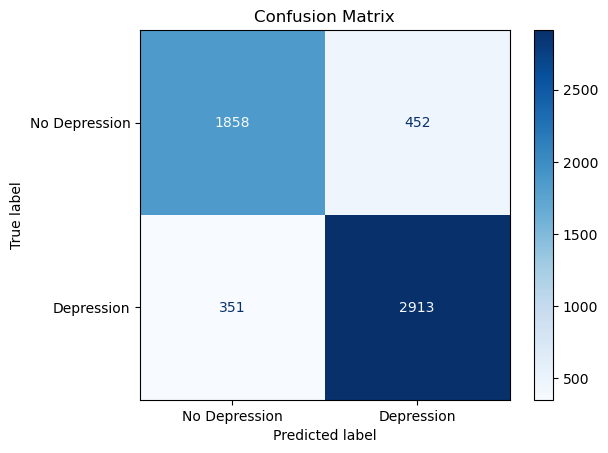

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Depression', 'Depression'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

AUC Score: 0.9245


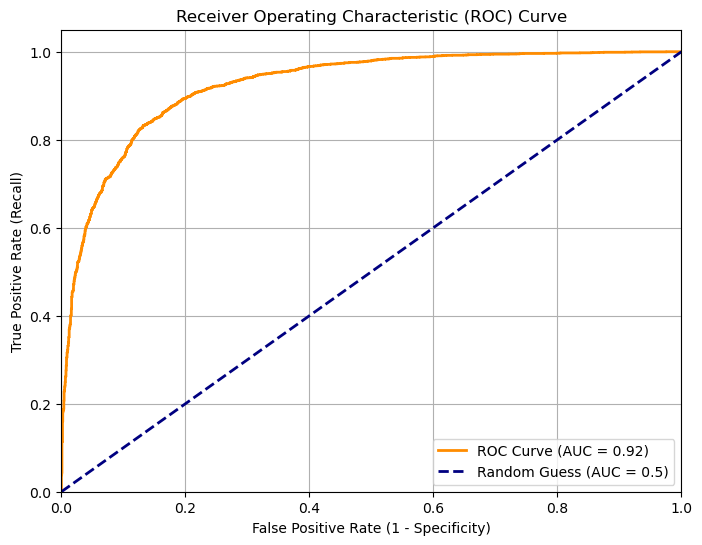

In [14]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, precision_recall_curve


# Get predicted probabilities for the positive class (Depression = 1)
y_probs = model.predict_proba(X_test_encoded_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate AUC score
roc_auc = auc(fpr, tpr)
print(f"AUC Score: {roc_auc:.4f}")

# Plot the ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [15]:
# the above evalution matrics are not enough because our data set is imbalanced 
# precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")


Precision: 0.8657


In [16]:
# recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")



Recall: 0.8925


In [17]:
# f1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")


F1 Score: 0.8789


PR AUC Score: 0.9414


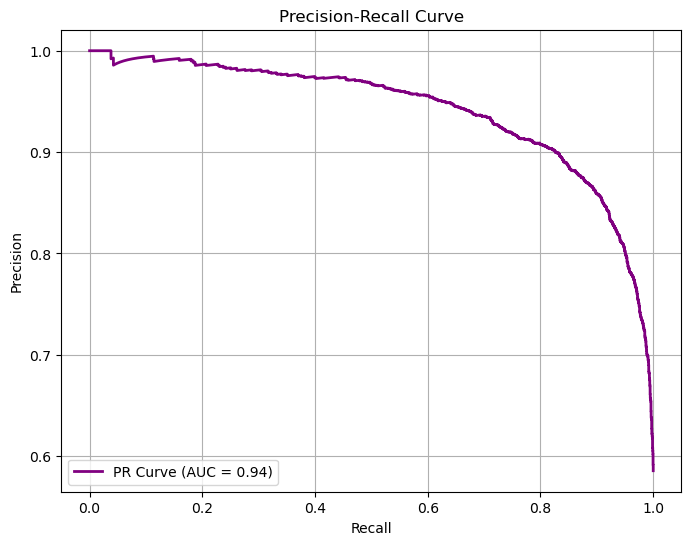

In [18]:
# precision recall curve

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Calculate AUC for PR curve
pr_auc = auc(recalls, precisions)
print(f"PR AUC Score: {pr_auc:.4f}")

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, color='purple', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [ ]:
## 